In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<Axes: xlabel='quality', ylabel='count'>

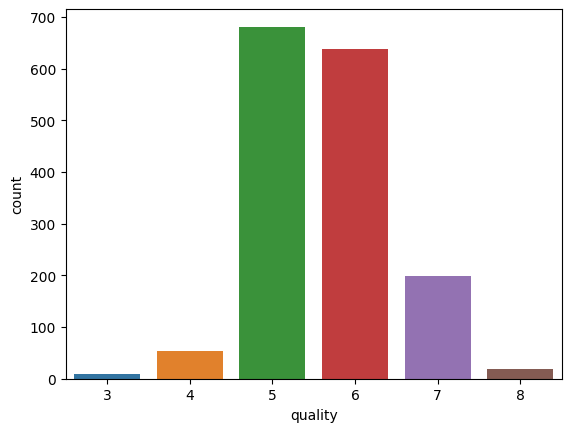

In [5]:
sns.countplot(x = 'quality', data=df)


In [6]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]


In [7]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


In [8]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)


In [9]:
# Visualize Class Distribution in Train, Val, and Test
# Once we’ve split our data into train, validation, and test sets, let’s make sure the distribution of classes is equal in all three sets.
# To do that, let’s create a function called get_class_distribution(). This function takes as input the obj y , ie. y_train, y_val, or y_test. Inside the function, we initialize a dictionary which contains the output classes as keys and their count as values. The counts are all initialized to 0.
# We then loop through our y object and update our dictionary.

def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict


Text(0.5, 1.0, 'Class Distribution in Test Set')

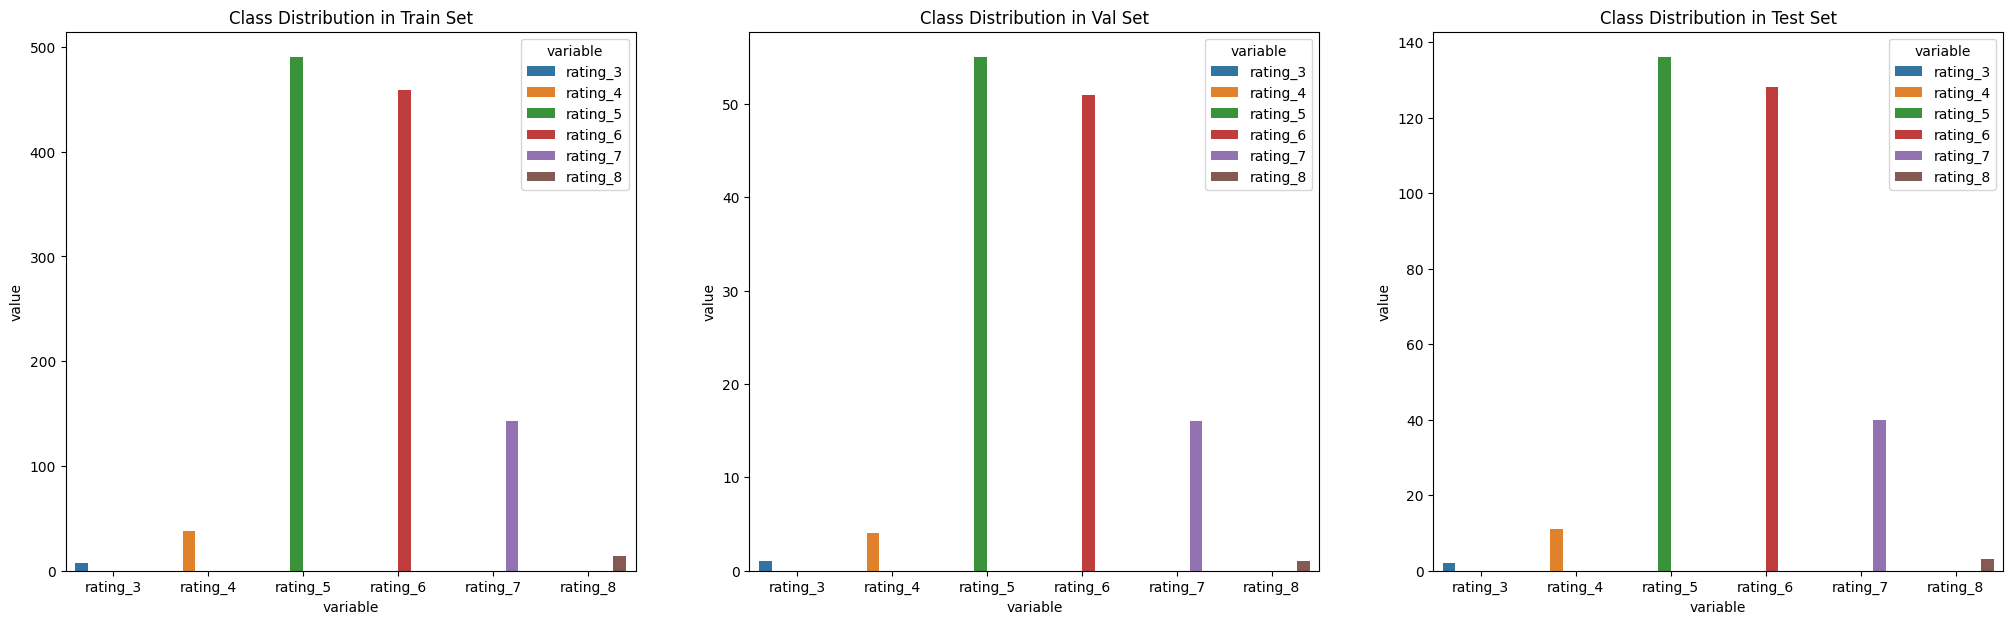

In [10]:
# Once we have the dictionary count, we use Seaborn library to plot the bar charts.
# To make the plot, we first convert our dictionary to a dataframe using pd.DataFrame.from_dict([get_class_distribution(y_train)]).
# Subsequently, we .melt() our convert our dataframe into the long format and finally use sns.barplot() to build the plots.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Val
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


In [11]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [12]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())


In [13]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)


In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [15]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
            x = self.relu(self.layer_1(inputs))
            x = self.relu(self.layer_2(x))
            x = self.relu(self.layer_3(x))
            x = self.layer_out(x)
            return (x)
    def predict(self, test_inputs):
            x = self.relu(self.layer_1(test_inputs))
            x = self.relu(self.layer_2(x))
            x = self.relu(self.layer_3(x))
            x = self.layer_out(x)
            return (x)


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###################### OUTPUT ######################
cuda:0


cpu


In [17]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)



MultipleRegression(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [18]:
loss_stats = {
    'train': [],
    "val": []
}


In [24]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 150: | Train Loss: 0.43304 | Val Loss: 0.38649


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

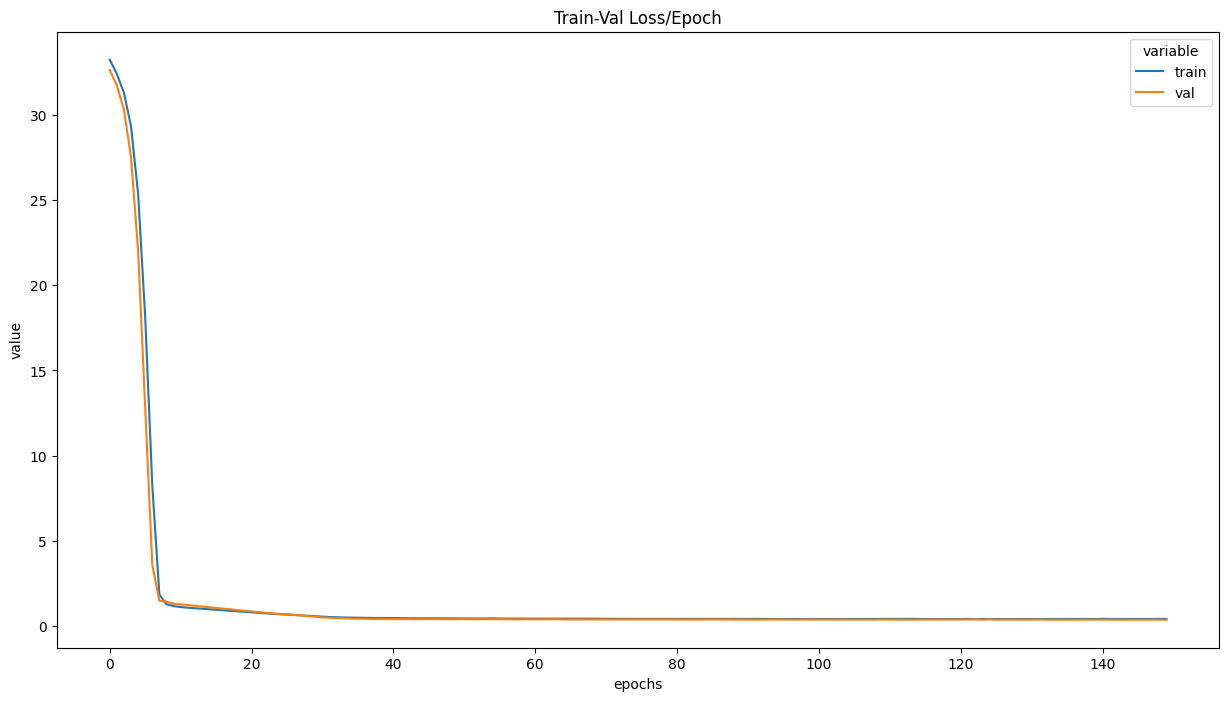

In [25]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')


In [26]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [27]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)



Mean Squared Error : 0.4179145675881408
R^2 : 0.35234500089252363
